## Assignment 7

The goal of this lab is to introduce the basic models used to simulate epidemics in networks, experiment with them and compare them. 
We will explore both types of diffusion models, decision-based and epidemic ones.
As a use case, we are going to use the coauthorship network of network scientists, which you can load with the function read gml from networkx library.

The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following
questions on the networks you have and submit your executable code.

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
path = ""

In [3]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)


download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")

The graph has 1589 nodes and 2742 edges


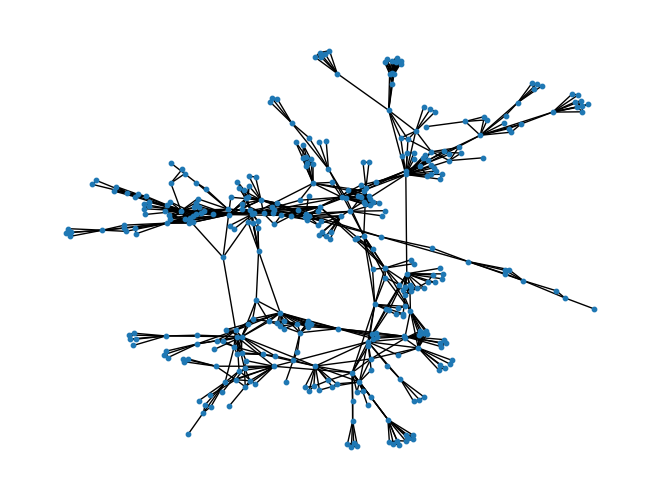

In [8]:
# Read the data and show the basic information
graph = nx.read_gml(path+"netscience.gml")
print(f"The graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges")

sub_graph = graph.subgraph(max(nx.connected_components(graph), key=len))
pos = nx.spring_layout(sub_graph)
nx.draw(sub_graph, pos, with_labels=False, edge_color='black', node_size=10)
plt.show()

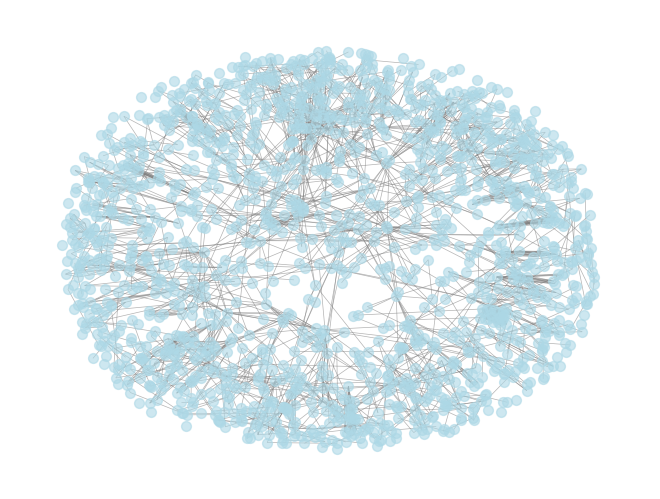

In [73]:
pos = nx.spring_layout(graph, seed=42, k=0.15) 

nx.draw(graph, pos, with_labels=False, node_size=50, font_size=10, font_color='black', 
        edge_color='gray', alpha=0.6, width=0.5, node_color='lightblue')

**(a)** The Sznajd model is a variant of spin model based on social impact, which
takes into account the fact that a group of individuals with the same opinion can influence their
neighbours more than one single individual. Please use the Sznajd model to simulate the cascade
of misinformation between the network of network scientists for 100 steps with different initial ”infected” numbers: 100, 300, and 700. Please visualize the results and output a prevalence plot. (May refer to NDlib.)

In [29]:
import matplotlib.pyplot as plt


def plot_diffusion_trend_and_prevalence(trends, num_iterations, total_nodes):
    # Initialize lists to track the number and fraction of nodes with each opinion
    
    # Get the counts of nodes with opinion +1 and -1
    #pos_count = iteration['node_count'][1]  # Nodes with opinion +1
    #neg_count = iteration['node_count'][-1]  # Nodes with opinion -1
    neg_count = trends[0]
    pos_count = trends[1]

    # Store fractions (for prevalence)
    pos_opinion_prevalence = [ i / total_nodes for i in pos_count]
    neg_opinion_prevalence = [ i / total_nodes for i in neg_count]

    # Create a figure with two subplots: one for Trend and one for Prevalence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Diffusion Trend (absolute pos_count)
    ax1.plot(range(num_iterations), pos_count, label="Positive Opinion (+1)", color='blue')
    ax1.plot(range(num_iterations), neg_count, label="Negative Opinion (-1)", color='red')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Number of Nodes')
    ax1.set_title('Diffusion Trend: Opinion Dynamics')
    ax1.legend()

    # Plot Diffusion Prevalence (fractions)
    ax2.plot(range(num_iterations), pos_opinion_prevalence, label="Positive Opinion (+1)", color='blue')
    ax2.plot(range(num_iterations), neg_opinion_prevalence, label="Negative Opinion (-1)", color='red')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Prevalence (Fraction of Nodes)')
    ax2.set_title('Diffusion Prevalence: Opinion Dynamics')
    ax2.legend()

    # Show the combined plot
    plt.tight_layout()
    plt.show()


To implement the sznajd model, i have referred to the following paper:
https://arxiv.org/pdf/cond-mat/0212042.pdf

in part 2 it says that the model works as follows:
- if $S_iS_{i+1} = 1$ then $S_{i-1}$ and $S_{i+2}$ take the direction of the pair $(i,i+1)$,
- if $S_iS_{i+1} = -1$ then $S_{i-1}$ takes the direction of $S_{i+1}$ and $S_{i+2}$ the direction of $S_i$.

In [ ]:
def sznajd_model(G, initial_infected_number, number_iterations):
    """
    Simulate the Sznajd model and plot the results.
    Implemented based on the following paper:
    Katarzyna Sznajd-Weron and Józef Sznajd (2000). Opinion evolution in closed community.
    https://arxiv.org/pdf/cond-mat/0101130

    The main part of the paper is:
    - if $S_iS_{i+1} = 1$ then $S_{i-1}$ and $S_{i+2}$ take the direction of the pair $(i,i+1)$,
    - if $S_iS_{i+1} = -1$ then $S_{i-1}$ takes the direction of $S_{i+1}$ and $S_{i+2}$ the direction of $S_i$.

    Args:
        G: networkx graph
        initial_infected_number: Number of initially infected (opinionated) nodes.
        number_iterations: Number of iterations for the simulation.
        
    Returns:
        trends: A dictionary containing opinion trends over iterations.
    """
    nodes = list(G.nodes)
    random.shuffle(nodes)
    nodes_index = {node: i for i, node in enumerate(nodes)}
    opinions = np.random.choice([0, 1], len(nodes))
    opinions[:initial_infected_number] = 1
    # since the nodes are shuffled, the first initial_infected_number nodes will be random nodes
    
    trends = [[], []]
    
    for _ in range(number_iterations):
        # in part 3 of the paper, the authors mention that:
        # "To investigate our model we perform a standard Monte Carlo simulation with random updating."
        # Therefore, I am choosing a random edge in each iteration
        edge = random.choice(list(G.edges))
        u, v = edge
        u_index, v_index = nodes_index[u], nodes_index[v]

        # if $S_iS_{i+1} = 1$ then $S_{i-1}$ and $S_{i+2}$ take the direction of the pair $(i,i+1)$,
        if opinions[u_index] == opinions[v_index]:
            consensus_opinion = opinions[u_index]
            for neighbor in G.neighbors(u):
                opinions[nodes_index[neighbor]] = consensus_opinion
            for neighbor in G.neighbors(v):
                opinions[nodes_index[neighbor]] = consensus_opinion
        else:
            # if $S_iS_{i+1} = -1$ then $S_{i-1}$ takes the direction of $S_{i+1}$ and $S_{i+2}$ the direction of $S_i$.
            for neighbor in G.neighbors(u):
                opinions[nodes_index[neighbor]] = opinions[v_index]
            for neighbor in G.neighbors(v):
                opinions[nodes_index[neighbor]] = opinions[u_index]

        pos_count = opinions.sum()
        neg_count = len(opinions) - pos_count
        trends[0].append(neg_count)
        trends[1].append(pos_count)
    
    assert len(trends[0]) == len(trends[1]) == number_iterations
    assert all(np.array(trends).sum(axis=0) == len(nodes))
    # Visualizations
    plt.plot(trends[0], label="Positive Opinion (+1)", color='blue')
    plt.plot(trends[1], label="Negative Opinion (-1)", color='red', alpha=0.4)
    # since both lines sum up to the total number of nodes, I have plotted one of them slightly transparent
    plt.xlabel('Iterations')
    plt.ylabel('Number of Nodes')
    plt.title('Diffusion Trend: Opinion Dynamics')
    plt.legend()    
    return np.array(trends)


For number of iterations:\
in the paper it is mentioned that:\
"The typical relaxation time for $N = 1000$ is $\sim 10^4$ Monte Carlo steps (MCS)

Since, we have 1584 nodes in the network, we can take 10000 iterations as well.

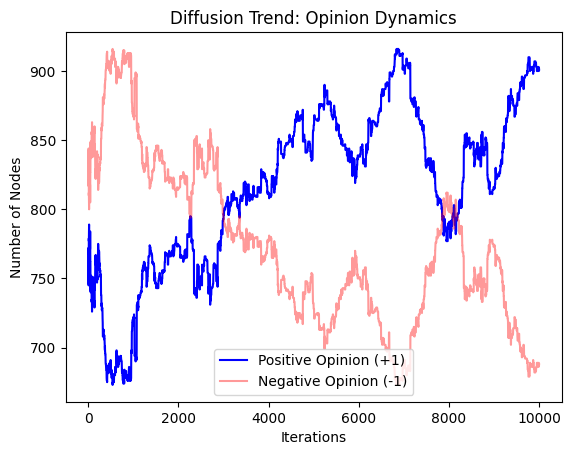

In [79]:
np.random.seed(0)
random.seed(0)

n_iter = 10000
t1 = sznajd_model(G=graph, initial_infected_number=5, number_iterations=n_iter)

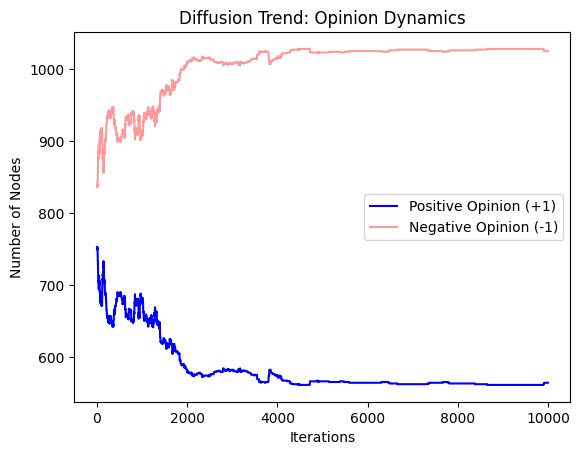

In [80]:
# Run sznajd for initial infected number: 15
t2 = sznajd_model(G=graph, initial_infected_number=15, number_iterations=n_iter)

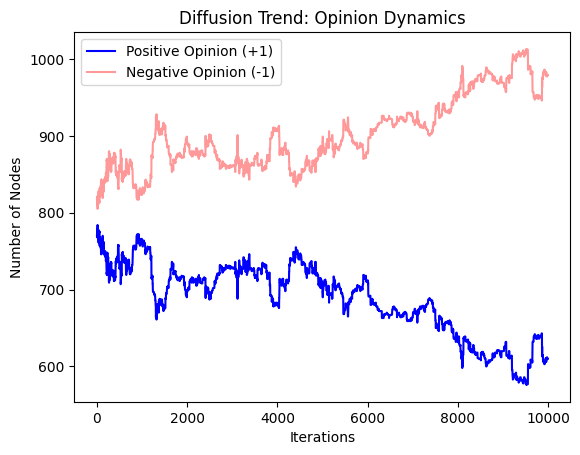

In [81]:
# Run sznajd for initial infected number: 30
t3 = sznajd_model(G=graph, initial_infected_number=30, number_iterations=n_iter)

**(b)** Although the interaction networks in real-life are different from the social networks we have, it is still meaningful to simulate the epidemics cascade with our dataset. The SIR model was introduced in 1927 by Kermack. In this model, during the course of an epidemic, a node is allowed to change its status from Susceptible (S) to Infected (I), then to Removed (R). Please use the SIR model to simulate for 100 iterations the cascade of the epidemic with the same number of initially infected nodes (suggested 0.5), with the following three sets of infection/removal probabilities: (0.5, 0.2), (0.3, 0.3), (0.4, 0.5) on the network science dataset, and visualize the results.

I have used the [wikipeida](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) page to implement the SIR model.

In [ ]:
def SIR_model(G, ini_infect, infection, removal, num_iterations):
    """
    Simulate the SIR (Susceptible-Infected-Recovered) model on a graph.

    Args:
        G: networkx graph
        ini_infect (float): Initial fraction of infected nodes (0 < ini_infect <= 1).
        infection (float): Probability of infection spreading (0 < infection <= 1).
        removal (float): Probability of infected nodes recovering and becoming immune (0 < removal <= 1).
        num_iterations (int): Number of iterations for the simulation.

    Returns:
        trends: Dictionary containing trends for S, I, and R over iterations.
    """
    if not 0 < ini_infect <= 1:
        raise ValueError("Initial fraction of infected nodes must be between 0 and 1.")
    if not 0 < infection <= 1:
        raise ValueError("Probability of infection spreading must be between 0 and 1.")
    if not 0 < removal <= 1:
        raise ValueError("Probability of recovery must be between 0 and 1.")

    # Initialize the states of nodes
    s, i, r = 0, 1, 2  # Susceptible, Infected, Recovered
    states = {node: s for node in G.nodes}

    # Infect an initial fraction of nodes randomly
    num_initial_infected = int(len(G.nodes) * ini_infect)
    initial_infected = random.sample(list(G.nodes), num_initial_infected)
    for node in initial_infected:
        states[node] = i

    # Initialize trends for tracking
    trends = {"S": [], "I": [], "R": []}

    # Simulation execution
    for _ in range(num_iterations):
        # Count current states
        num_s = num_i = num_r = 0
        for node in G.nodes:
            num_s += states[node] == s
            num_i += states[node] == i
            num_r += states[node] == r
        trends["S"].append(num_s)
        trends["I"].append(num_i)
        trends["R"].append(num_r)

        # If no one is infected, stop the simulation
        if num_i == 0:
            break

        # Process infection and recovery
        new_states = states.copy()
        for node in G.nodes:
            if states[node] == i:
                # Try to infect neighbors
                for neighbor in G.neighbors(node):
                    if states[neighbor] == s and random.random() < infection:
                        new_states[neighbor] = i
                # Try to recover
                if random.random() < removal:
                    new_states[node] = r
        states = new_states

    # Visualization: Trends over time
    plt.figure(figsize=(10, 6))
    plt.plot(trends["S"], label="Susceptible (S)", color="blue")
    plt.plot(trends["I"], label="Infected (I)", color="red")
    plt.plot(trends["R"], label="Recovered (R)", color="green")
    plt.xlabel("Iterations")
    plt.ylabel("Number of Nodes")
    plt.title("SIR Model: Dynamics Over Time")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return trends


Running SIR model simulation for 0.5 infection probability and 0.2 removal probability.


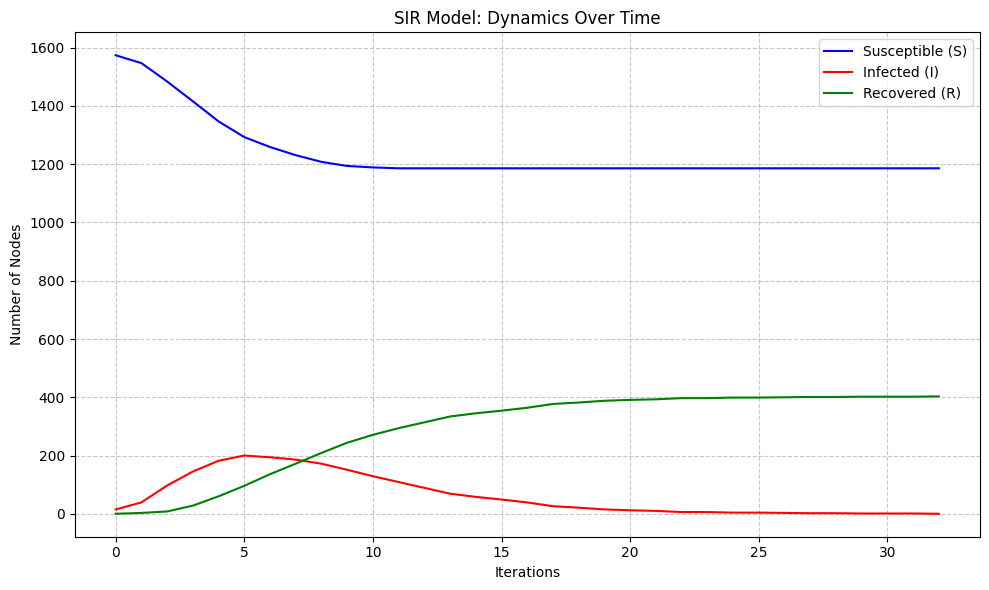

In [83]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.5, 0.2))
trends = SIR_model(G=graph, ini_infect=0.01, infection=0.5, removal=0.2, num_iterations=1000)

Running SIR model simulation for 0.3 infection probability and 0.3 removal probability.


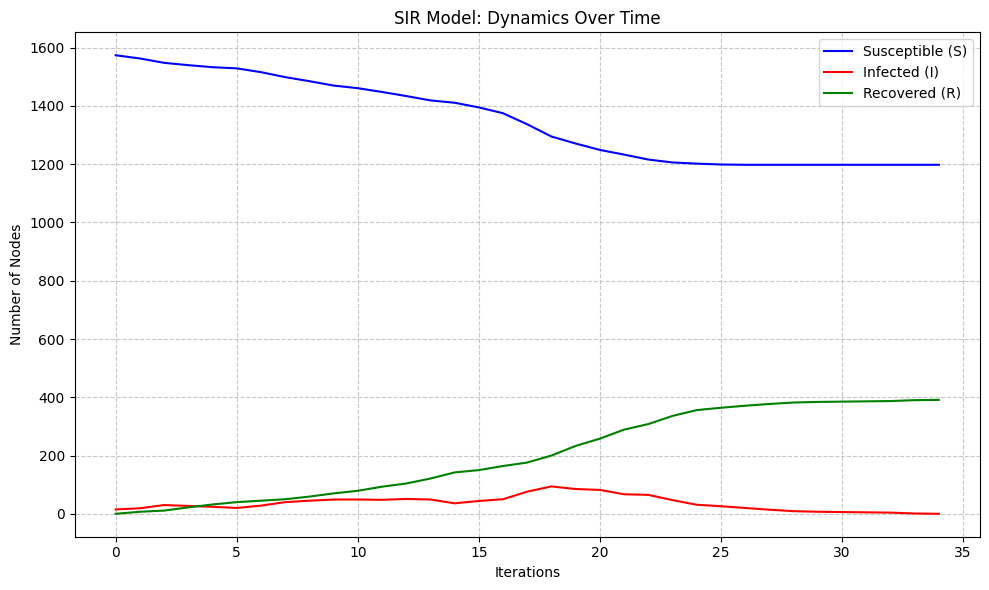

In [84]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.3, 0.3))
trends = SIR_model(G=graph, ini_infect=0.01, infection=0.3, removal=0.3, num_iterations=1000)

Running SIR model simulation for 0.4 infection probability and 0.5 removal probability.


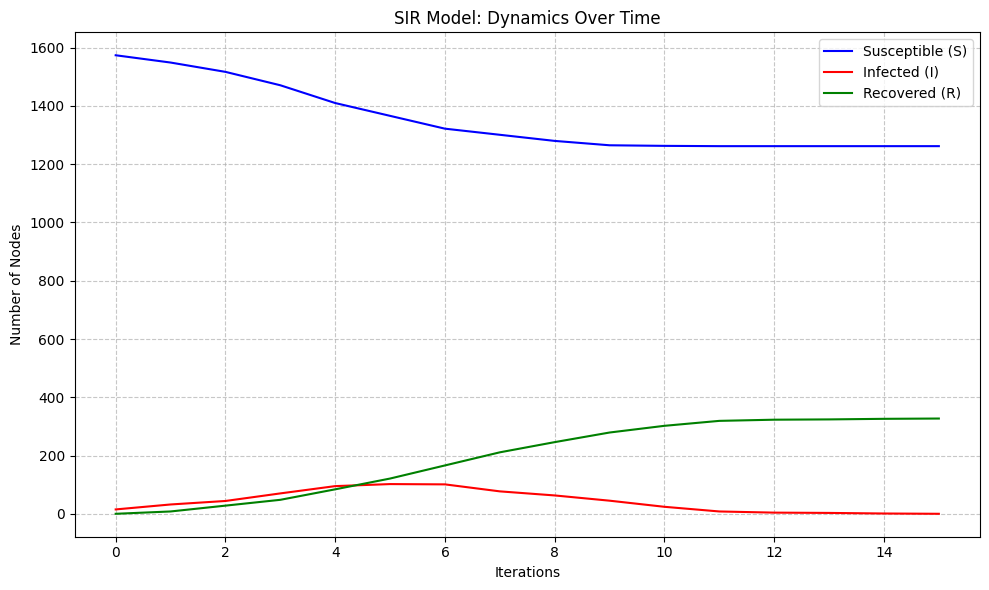

In [85]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.4, 0.5))
trends = SIR_model(G=graph, ini_infect=0.01, infection=0.4, removal=0.5, num_iterations=1000)

Running SIR model simulation for 0.4 infection probability and 0.5 removal probability.


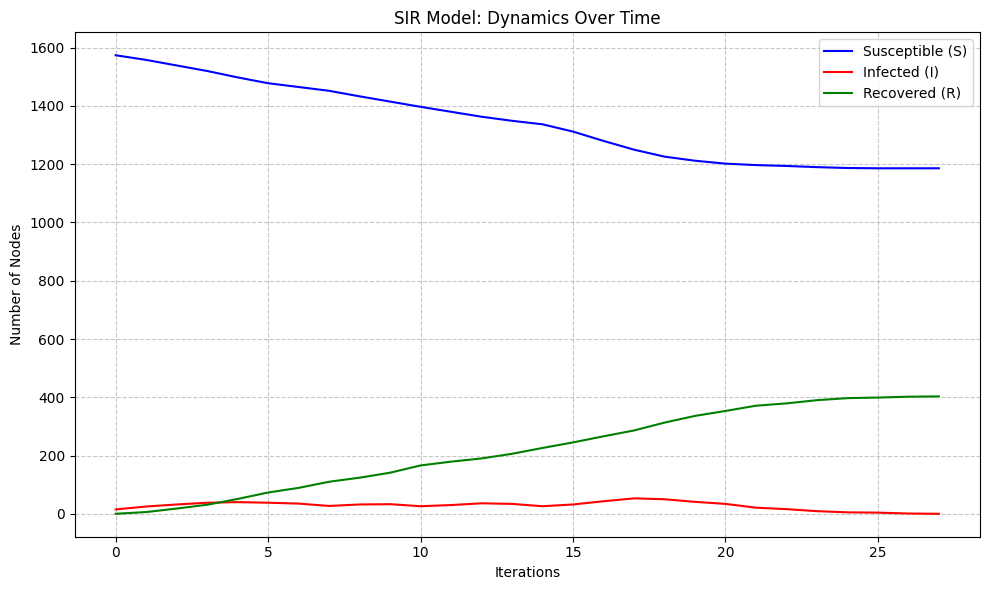

In [86]:
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(0.4, 0.5))
trends = SIR_model(G=graph, ini_infect=0.01, infection=0.4, removal=0.5, num_iterations=1000)